<a href="https://colab.research.google.com/github/aparedesum/ProductivityPrediction/blob/main/EvaluacionModelosProductividad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Para el presente trabajo, se tomaron como referencias los siguientes trabajos:
- https://www.kaggle.com/code/eminecerit/notebook-garment-classification
- https://github.com/romeroc42/GarmentProductivity
- https://www.mikulskibartosz.name/xgboost-hyperparameter-tuning-in-python-using-grid-search/
- https://www.kaggle.com/code/sociopath00/random-forest-using-gridsearchcv/notebook

# **Cargamos el dataset**

In [2]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


In [3]:
df = pd.read_csv('garments_worker_productivity.csv')

# **Leyendo información del dataset**

In [4]:
print("Cantidad de filas y columnas: ", df.shape)

Cantidad de filas y columnas:  (1197, 15)


In [5]:
# Información de la distribución de los datos en el dataset
df.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,691.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,3.463963,0.097891,10.943219,1837.455001,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,774.500000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,6.000000,0.750000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,9.000000,0.800000,24.260000,1252.500000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


In [6]:
df.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


# **Pre procesamiento de datos**

In [10]:
# Obtenemos year, month, week, day_of_month en columnas separadas
# Renombramos el nombre de la columna day a day_of_week
df["year"] = pd.DatetimeIndex(df['date']).year
df["month"] = pd.DatetimeIndex(df['date']).month
df["week"] = pd.DatetimeIndex(df['date']).week
df["day_of_month"] = pd.DatetimeIndex(df['date']).day
df.rename(columns = {"day":"day_of_week"}, inplace = True)

df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  """


,date,quarter,department,day_of_week,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,year,month,week,day_of_month
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,2015,1,1,1
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500,2015,1,1,1
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,2015,1,1,1
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,2015,1,1,1
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382,2015,1,1,1


In [11]:
# Analizando la columna quarter, department, day_of_week
print(df["quarter"].unique())
print(df["department"].unique())
print(df["day_of_week"].unique())

['Quarter1' 'Quarter2' 'Quarter3' 'Quarter4' 'Quarter5']
['sweing' 'finishing ' 'finishing']
['Thursday' 'Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday']


In [13]:
# Analizando la columna department, se necesita limpiar espacios en los extremos
df['department'] = df['department'].str.strip()

In [14]:
#Verificamos los valores unicos en cada columna
df.nunique()

date                      59
quarter                    5
department                 2
day_of_week                6
team                      12
targeted_productivity      9
smv                       70
wip                      548
over_time                143
incentive                 48
idle_time                 12
idle_men                  10
no_of_style_change         3
no_of_workers             61
actual_productivity      879
year                       1
month                      3
week                      11
day_of_month              30
dtype: int64

In [15]:
# Removemos columna year y date
df.drop(columns=["year"], inplace=True)
df.drop(columns=["date"], inplace=True)

In [16]:
#Reemplamos los valores nan en la columna wip con la el valor 0
wip_mean = df["wip"].mean()
df["wip"].fillna(0, inplace = True)

In [17]:
#Aplicando encoding
df=pd.get_dummies(df)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   team                   1197 non-null   int64  
 1   targeted_productivity  1197 non-null   float64
 2   smv                    1197 non-null   float64
 3   wip                    1197 non-null   float64
 4   over_time              1197 non-null   int64  
 5   incentive              1197 non-null   int64  
 6   idle_time              1197 non-null   float64
 7   idle_men               1197 non-null   int64  
 8   no_of_style_change     1197 non-null   int64  
 9   no_of_workers          1197 non-null   float64
 10  actual_productivity    1197 non-null   float64
 11  month                  1197 non-null   int64  
 12  week                   1197 non-null   int64  
 13  day_of_month           1197 non-null   int64  
 14  quarter_Quarter1       1197 non-null   uint8  
 15  quar

In [22]:
df.head()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,...,quarter_Quarter4,quarter_Quarter5,department_finishing,department_sweing,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,...,0,0,0,1,0,0,0,1,0,0
1,1,0.75,3.94,0.0,960,0,0.0,0,0,8.0,...,0,0,1,0,0,0,0,1,0,0
2,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,...,0,0,0,1,0,0,0,1,0,0
3,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,...,0,0,0,1,0,0,0,1,0,0
4,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,...,0,0,0,1,0,0,0,1,0,0


In [23]:
df.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,...,quarter_Quarter4,quarter_Quarter5,department_finishing,department_sweing,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
count,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,...,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,687.228070,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,...,0.207185,0.036759,0.422723,0.577277,0.166249,0.156224,0.169591,0.166249,0.167920,0.173768
std,3.463963,0.097891,10.943219,1514.582341,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,...,0.405458,0.188247,0.494199,0.494199,0.372460,0.363219,0.375430,0.372460,0.373951,0.379068
min,1.000000,0.070000,2.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.700000,3.940000,0.000000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,0.750000,15.260000,586.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000,0.800000,24.260000,1083.000000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
#Se crea la columna diferencia
df['diferencia'] = df.actual_productivity -df.targeted_productivity
df.columns


Index(['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive',
       'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers',
       'actual_productivity', 'month', 'week', 'day_of_month',
       'quarter_Quarter1', 'quarter_Quarter2', 'quarter_Quarter3',
       'quarter_Quarter4', 'quarter_Quarter5', 'department_finishing',
       'department_sweing', 'day_of_week_Monday', 'day_of_week_Saturday',
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'diferencia'],
      dtype='object')

In [25]:
#Detalle de la columna creada
df['diferencia'].describe()

count    1197.000000
mean        0.005459
std         0.160082
min        -0.561958
25%        -0.009556
50%         0.000505
75%         0.099111
max         0.644375
Name: diferencia, dtype: float64

In [26]:
#Creando una columna nueva para tener el target

df["Target"] = np.nan
df.loc[df['diferencia']<0,'Target']=-1
df.loc[(df['diferencia']>0), 'Target']=1
df.loc[df['diferencia']==0, 'Target']=0

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,...,department_finishing,department_sweing,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,diferencia,Target
0,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,...,0,1,0,0,0,1,0,0,0.140725,1.0
1,1,0.75,3.94,0.0,960,0,0.0,0,0,8.0,...,1,0,0,0,0,1,0,0,0.136500,1.0
2,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,...,0,1,0,0,0,1,0,0,0.000570,1.0
3,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,...,0,1,0,0,0,1,0,0,0.000570,1.0
4,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,...,0,1,0,0,0,1,0,0,0.000382,1.0
5,7,0.80,25.90,984.0,6720,38,0.0,0,0,56.0,...,0,1,0,0,0,1,0,0,0.000125,1.0
6,2,0.75,3.94,0.0,960,0,0.0,0,0,8.0,...,1,0,0,0,0,1,0,0,0.005167,1.0
7,3,0.75,28.08,795.0,6900,45,0.0,0,0,57.5,...,0,1,0,0,0,1,0,0,0.003683,1.0
8,2,0.75,19.87,733.0,6000,34,0.0,0,0,55.0,...,0,1,0,0,0,1,0,0,0.003098,1.0
9,1,0.75,28.08,681.0,6900,45,0.0,0,0,57.5,...,0,1,0,0,0,1,0,0,0.000428,1.0


In [28]:
# Verificamos la cantidad de valores del Target
df['Target'].value_counts()

 1.0    869
-1.0    322
 0.0      6
Name: Target, dtype: int64

# **Aplicando ML**

In [29]:
from pandas.core.common import random_state
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,confusion_matrix,plot_confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [33]:
#Separando la data en dos partes para aplica ML
X= df.drop('Target',axis=1)
y= df['Target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,random_state=0)

**1er Algoritmo: DecisionTreeClassifier**

Accuracy:  0.9958333333333333
Precision:  0.6666666666666666
Recall:  0.6647727272727272
f1-score:  0.6657169990503324


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


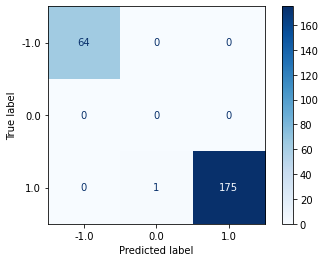

In [34]:
from sklearn.tree import DecisionTreeClassifier

decision_model = DecisionTreeClassifier(random_state=0)
decision_model.fit(X_train, y_train)
y_pred = decision_model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average='macro'))
print('Recall: ', recall_score(y_test, y_pred,average='macro', zero_division=0))
print('f1-score: ', f1_score(y_test, y_pred,average='macro'))
plot_confusion_matrix(decision_model, X_test, y_test,cmap=plt.cm.Blues)

**2do Algoritmo: RandomForestClassifier**

Accuracy:  0.9541666666666667
Precision:  0.9705882352941176
Recall:  0.9140625
f1-score:  0.9378399378399378


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


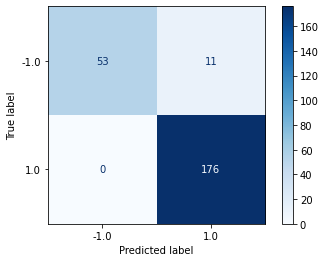

In [35]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(max_depth=2, random_state=0)
random_forest_model.fit(X_train,y_train)
y_pred = random_forest_model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average="macro"))
print('Recall: ', recall_score(y_test, y_pred, average="macro", zero_division=0))
print('f1-score: ', f1_score(y_test, y_pred, average="macro"))
plot_confusion_matrix(random_forest_model, X_test, y_test,cmap=plt.cm.Blues)

**3er Algoritmo: SVM**

Accuracy:  0.7333333333333333
Precision:  0.36666666666666664
Recall:  0.5
f1-score:  0.423076923076923


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


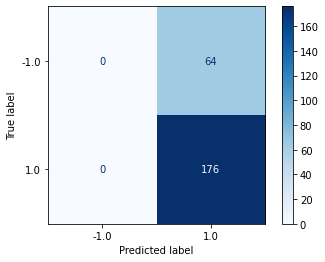

In [36]:
from sklearn.svm import SVC

# Ajuste de modelo con kernel gaussiano
svc_model = SVC(kernel='rbf', C=1, gamma=50)
svc_model.fit(X_train,y_train)
y_pred = svc_model.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average="macro"))
print('Recall: ', recall_score(y_test, y_pred, average="macro", zero_division=0))
print('f1-score: ', f1_score(y_test, y_pred, average="macro"))

plot_confusion_matrix(svc_model, X_test, y_test,cmap=plt.cm.Blues)

**4to Algoritmo: XGBClassifier**

Accuracy:  0.7333333333333333
Precision:  0.36666666666666664
Recall:  0.5
f1-score:  0.423076923076923


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


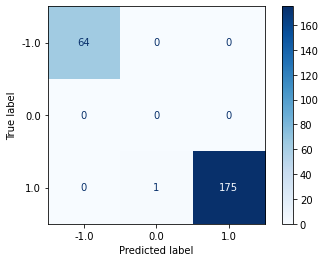

In [ ]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(n_jobs=1).fit(X_train, y_train)
predictions = xgb_model.predict(X_test)
actuals = y_test
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average="macro"))
print('Recall: ', recall_score(y_test, y_pred, average="macro", zero_division=0))
print('f1-score: ', f1_score(y_test, y_pred, average="macro"))
plot_confusion_matrix(xgb_model, X_test, y_test,cmap=plt.cm.Blues)


- Calculo de hiperparámetroas
Se puede observar, que el mejor resultado lo obtuvimos cuando aplicamos RandomForestClassifier, poor lo que nos enfocaremos en calcular los hiperparámetros para este algoritmo.

Mejores hiper parametros: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200}
Accuracy:  0.9958333333333333
Precision:  0.6666666666666666
Recall:  0.6647727272727272
f1-score:  0.6657169990503324


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


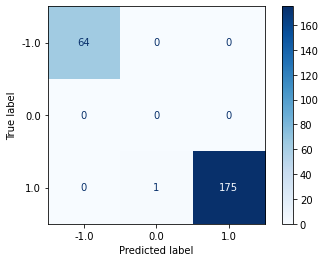

In [44]:
parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32,None]}

param_grid = { 
    'n_estimators': [5, 10, 50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2, 4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid.fit(X_train,y_train)
print("Mejores hiper parametros:", grid.best_params_)

model = grid.best_estimator_
y_pred = model.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average="macro"))
print('Recall: ', recall_score(y_test, y_pred, average="macro", zero_division=0))
print('f1-score: ', f1_score(y_test, y_pred, average="macro"))
plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues)